In [111]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mizani.formatters import percent_format
from plotnine import *
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm
from IPython.core.display import HTML
from stargazer.stargazer import Stargazer
import statsmodels.nonparametric.kernel_regression as loess

from mizani.transforms import log_trans
from mizani.formatters import percent_format
from mizani.formatters import log_format

# Get the data

In [112]:
# Read the csv and feed it into the variable xc
xc = pd.read_csv("morg-2014-emp.csv")

# Filter dataset for healthcare practitioners
xc = xc.loc[((xc["occ2012"] >= 3000) & (xc["occ2012"] <= 3540))]

C:\Users\iandr\AppData\Local\Temp\ipykernel_30500\1807558595.py:2: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.


In [113]:
# Create Variables
xc["female"] = (xc["sex"] == 2)
xc["w"] = xc["earnwke"] / xc["uhours"]
xc["lnw"] = np.log(xc["w"])
xc["agesq"] = np.power(xc["age"], 2)

In [114]:
xc['female'] = pd.to_numeric(xc['female'], errors='coerce')
xc['grade92'] = pd.to_numeric(xc['grade92'], errors='coerce')
xc['w'] = pd.to_numeric(xc['w'], errors='coerce')
xc = xc.dropna(subset=['female', 'grade92', 'w'])
xc["female"].value_counts()

female
True     7220
False    1988
Name: count, dtype: int64

# 1.: Show the unconditional gender gap

In [115]:
reg1 = smf.ols(formula="lnw~female", data=xc).fit(cov_type="HC1")
reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lnw   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     60.71
Date:                Sat, 25 Nov 2023   Prob (F-statistic):           7.34e-15
Time:                        03:20:29   Log-Likelihood:                -8501.1
No. Observations:                9208   AIC:                         1.701e+04
Df Residuals:                    9206   BIC:                         1.702e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.3329      0.015    215.323      0.000       3.303       3.363
female[T.True]    -0.1320      0.017     -7.791      0.000      -0.165      -0.099
==============================================================================
Omnibus:                     8464.256   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1700709.478
Skew:                          -3.808   Prob(JB):                         0.00
Kurtosis:                      69.142   Cond. No.                         4.09
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

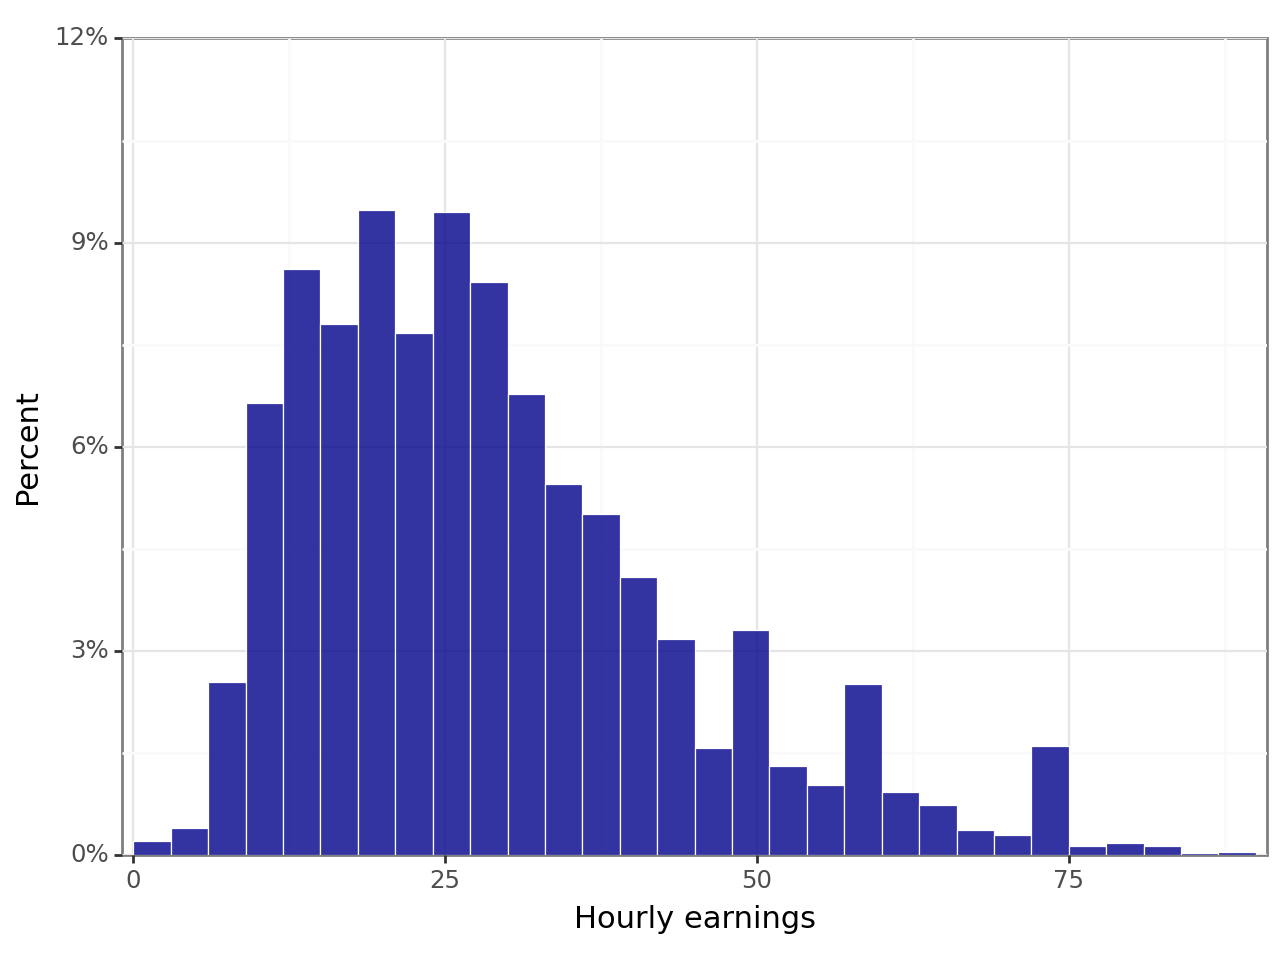

<Figure Size: (640 x 480)>

In [116]:
(
    ggplot(xc, aes(x="w", y="stat(count)/sum(stat(count))"))
    + geom_histogram(
        binwidth=3,
        boundary=0,
        color="white",
        fill = "darkblue",
        size=0.25,
        alpha=0.8,
        show_legend=False,
        na_rm=True,
    )
    + labs(x="Hourly earnings", y="Percent")
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 90))
    + scale_y_continuous(
        labels=percent_format(), #mizani
        limits=(0, 0.12),
        expand=(0.0, 0.0),
    )
    + theme_bw()
)


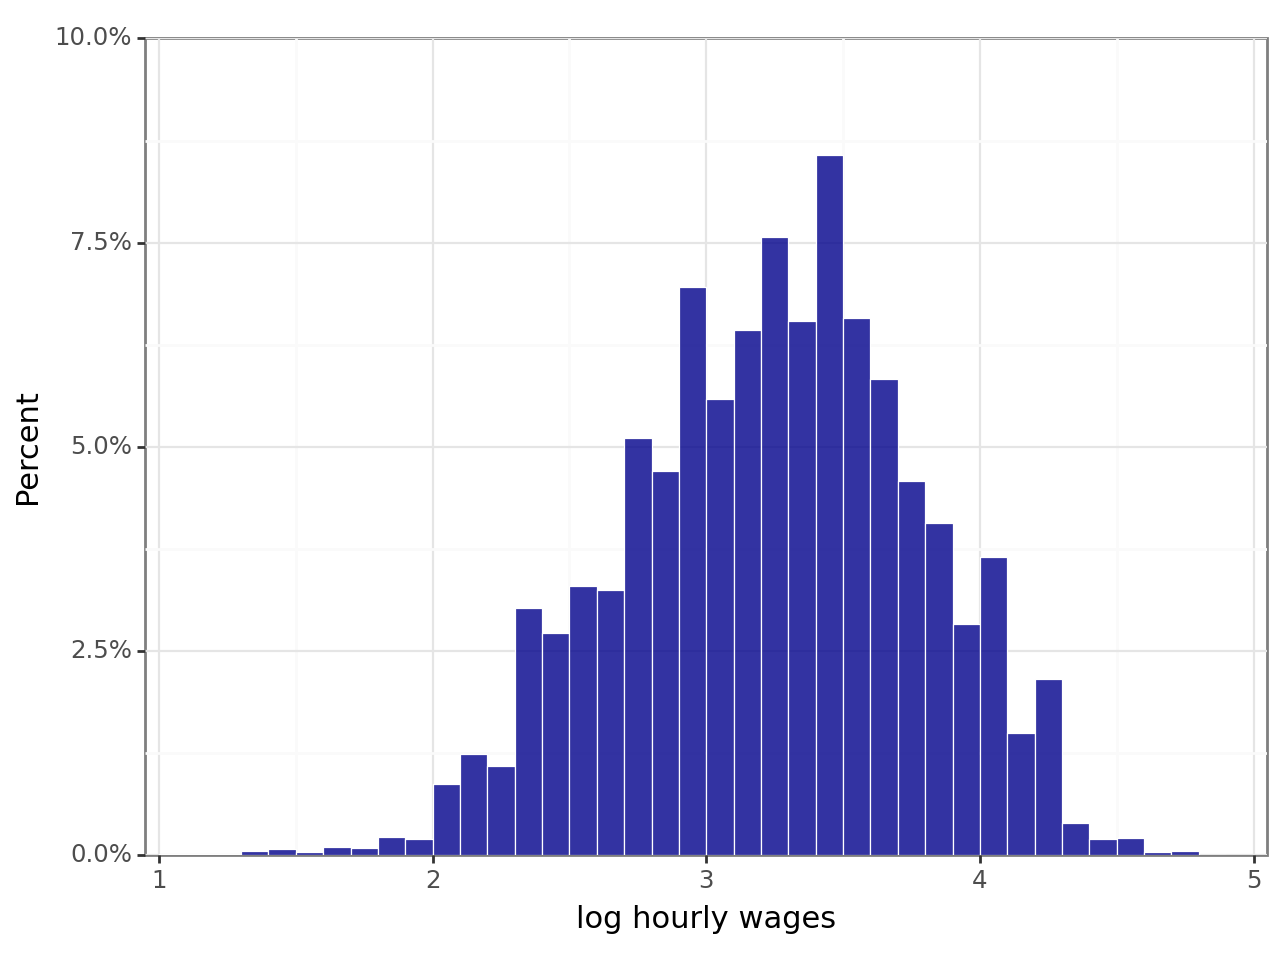

<Figure Size: (640 x 480)>

In [117]:
(
    ggplot(xc, aes(x="lnw", y="stat(count)/sum(stat(count))"))
    + geom_histogram(
        binwidth=0.1,
        boundary=0,
        color="white",
        fill = "darkblue",
        size=0.25,
        alpha=0.8,
        show_legend=False,
        na_rm=True,
    )
    + labs(x="log hourly wages", y="Percent")
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(1, 5))
    + scale_y_continuous(
        expand=(0.0, 0.0),
        limits=(0, 0.1),
        labels=percent_format(), #mizani
    )
    + theme_bw()
)

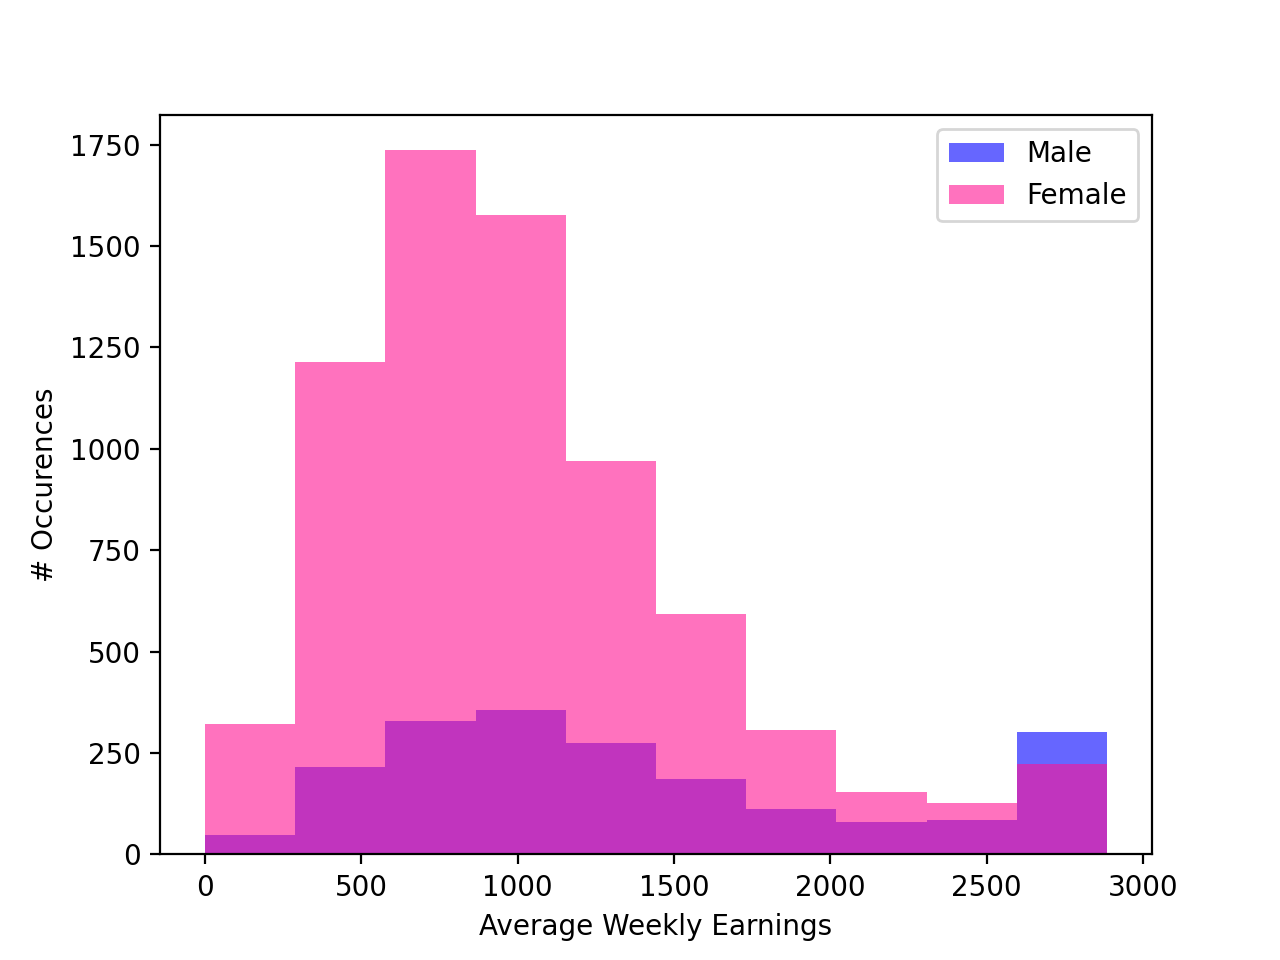

In [118]:
plt.hist(xc[xc["sex"] == 1]["earnwke"].reset_index(drop = True), alpha = 0.6, label = "Male", color = "blue")
plt.hist(xc[xc["sex"] == 2]["earnwke"].reset_index(drop = True), alpha = 0.6, label = "Female", color = "deeppink")
plt.xlabel("Average Weekly Earnings")
plt.ylabel("# Occurences")
plt.legend()
plt.show()

In [119]:
xc.loc[:, ["earnwke", "uhours", "w", "lnw"]].describe()

,earnwke,uhours,w,lnw
count,9208.000000,9208.000000,9208.000000,9208.000000
mean,1124.188752,38.541486,29.366761,3.229424
std,658.624137,9.863961,16.773557,0.611589
min,0.010000,1.000000,0.000200,-8.517193
25%,660.000000,36.000000,17.667500,2.871727
50%,980.000000,40.000000,26.000000,3.258097
75%,1420.200000,40.000000,37.393056,3.621485
max,2884.610000,99.000000,432.500000,6.069582


# 2. Show how the gender gap varies with the level of education. Consider several options to model the relationship.

## Level of Education

In [120]:
# Set variables

xc['BA_degree'] = (xc['grade92'] == 43).astype(int)
xc['MA_degree'] = (xc['grade92'] == 44).astype(int)
xc['Prof_degree'] = (xc['grade92'] == 45).astype(int)
xc['PhD_degree'] = (xc['grade92'] == 46).astype(int)

#Applied qualitative variables:

def EducationLvl(row):
    if row["grade92"] == 43:
        return "BA_degree"
    elif row["grade92"] == 44:
        return "MA_degree"
    elif row["grade92"] == 45:
        return "Prof_degree"
    elif row["grade92"] == 46:
        return "PhD_degree"
    else:
        return "Other"
    
xc["Education"] = xc.apply(EducationLvl, axis = 1)

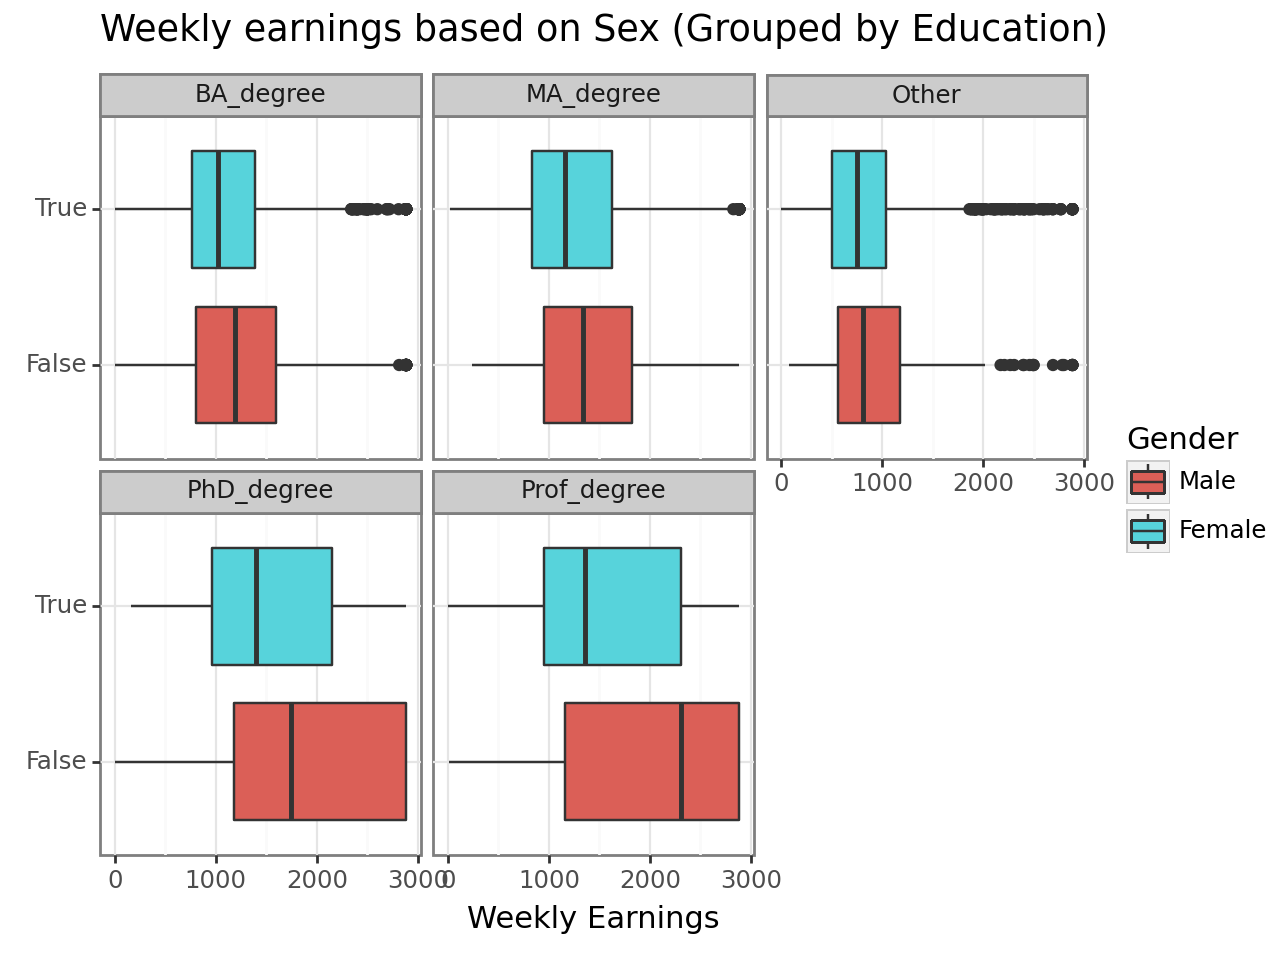

<Figure Size: (640 x 480)>

In [121]:
(
    ggplot(data=xc) +
    aes(x="female", y="earnwke", fill="female") +  # Corrected here
    geom_boxplot() +
    coord_flip() +
    facet_wrap("~Education") +  # Assuming 'Education' is a column in your dataframe
    theme_bw() +
    scale_fill_discrete(labels=["Male", "Female"]) +
    labs(title="Weekly earnings based on Sex (Grouped by Education)", x="", y="Weekly Earnings", fill="Gender")
)

## First set of regression models

In [122]:
xc["female"] = xc["female"].astype(int)  #from boolean to 0,1
reg6 = smf.ols(formula="lnw~female", data=xc).fit(cov_type="HC1") #unconditional
reg7 = smf.ols(formula="lnw~female+grade92", data=xc).fit(cov_type="HC1") #level of education enters linearly
reg8 = smf.ols(formula="lnw~female+grade92+BA_degree", data=xc).fit(cov_type="HC1") #add quadratic
reg9 = smf.ols(formula="lnw~female+grade92+BA_degree+MA_degree+Prof_degree", data=xc).fit(cov_type="HC1")
reg10 = smf.ols(formula="lnw~female+grade92+BA_degree+MA_degree+Prof_degree+PhD_degree", data=xc).fit(cov_type="HC1")#4-th order polynomial

In [123]:
stargazer = Stargazer([reg6, reg7, reg8, reg9, reg10])
stargazer.covariate_order(["female", "grade92", "BA_degree", "MA_degree", "Prof_degree", "PhD_degree", "Intercept"])
stargazer.rename_covariates({"grade92": "Level_of_Education", "Intercept": "Constant"})
stargazer

### Interpretation of regressions 6 - 10
- Reg6: This regression shows the unconditional wage gap. With a p-value below 0.01, this suggests that the data provides evidence in support of the hypothesis that being female in general yields lower wages, specifically a decrease of 0.132 in the log wages. An R-Squared of 0.8% suggests that attempting to explain the wage gap using gender alone is not a good model fit at all. The F-statistic is significant at the 1% level, suggesting that gender has an association with wages, and that there is a significant wage gap between men and women where women get paid less. 

- Reg7: This regression takes into considering the level of education. The female coefficient of -0.035 is statistically significant at the 1% level, and suggests lower wages for women compared to men while including education. Additionally, the statistically significant coefficient for level of education suggests that additional levels of education are associated with an increase in wages. The R-Squared increased to 13.5% from 0.8%, since education is being considered. This means that level of education provides a better model fit than just gender alone; however, this R-Squared is still low and suggests that education alone is not enough to fit the model appropriately. The F-statistic is statistically significant at the 1% level, suggesting that this data provides evidence in support of a gender-wage gap. The R-Squared coefficient remains low, which should be considered for more accurate modeling. 

- Reg8: This regression considers the addition of BA degree. The female coefficient of -0.043 is still statistically significant; however it is lower than the coefficient found in Reg7. This could be explained by the fact that the level of education considers all education collectively, whereas BA degrees only consider the one degree. Since this data is specifically filtered to medical practitioners, many will have higher degrees than just a BA degree. Regardless, the difference between the Reg8 and Reg6 coefficient suggests that the addition of a BA degree might influence a degree in the wage gap, but does not eliminate a wage gap. The BA Degree statistically significant coefficient of 0.63 also represents an increase in wage with the addition of a BA degree. Additionally, the R-Squared value does not change much from the previous model, and the F-statistic remains statistically sigificant. Finally, the coe

- Reg9: In this regression model, the MA degrees and professional degrees is considered. Here, a statistically significant increase in log wages can be seen in the coefficient of 0.099 as compared to the BA degree coefficient of 0.063; however, the female coefficient of -0.046 for Reg9 is actually lower than the female coefficient of -0.043 from Reg8. This suggests that the wage gap is slightly larger at the the MA Degree and professional degree level. This could be explained by the fact that most medical practioners will have at least a MA degree or professional degree rather than a BA degree. The R-Squared has slightly increased to 13.9%, which is still an increase from the unconditional log wage and gender regression model; however, it is still not a very high R-Squared. The F-statistic remains statisticaly significant, implying an association between gender, level of education, and wages. 

- Reg10: This regression model includes all levels of education from BA degree up to PhD degree. With a statistically significant coefficient of -0.045, females still experience a wage gap with a PhD degree. Having a PhD degree does not seem to yeild as high as a wage increase in comparison to having other degrees, with a coefficient of 0.018 that is not statistically significant. The R-Squared is the same as in Reg9, indicating the addition of a PhD degree does not necesarily make the model more refined. Additionally, the F-Statistic still remains statistically singificant, implying this data provides statistically significant evidence in support of a gender wage gap, even up to PhD degree holders. 

Overall, the Residual Standard Error decreased from the unconditional log wage and gender model. This implies the addition of education does yeild an impact on the results, making them more reliable; however, the Residual Standard Error only slightly decreased throughout the additions of different educational levels. 

## Second set of regression models

In [124]:
reg11 = smf.ols(formula="lnw~grade92", data=xc.query("female==1")).fit(cov_type="HC1")
reg12 = smf.ols(formula="lnw~grade92", data=xc.query("female==0")).fit(cov_type="HC1")
reg13 = smf.ols(formula="lnw~female+grade92+grade92*female", data=xc).fit(cov_type="HC1")

stargazer = Stargazer([reg11, reg12, reg13])
stargazer.covariate_order(["female", "grade92", "grade92:female", "Intercept"])
stargazer.rename_covariates({"female": "Female", "Intercept": "Constant", "grade92": "Level of Education", "grade92:female": "Female x Level of Education"})
stargazer.custom_columns(["Women", "Men", "All"], [1, 1, 1])
stargazer

### Interpretation of Regressions 11-13
- Reg11: This regression model takes a look at females and how an increase in their level of education impacts their wages. The statistically significant coefficient for the level of education is 0.121, representing an increase of 12.1% in log wages per increase in level of education for women. The constant of -1.930 does not seem reasonable to consider in this case, because the number of individuals in the medical practitioner field with zero education should not exist. The R-Squared suggests that 13.3% of the variability of women's log wages can be explained by the level of education. The F-statistic here suggests that this model is highly statistically significant. 

- Reg12: This regression model focuses on the earnings of men and how their wage increases based on the increase in level of education. According to the statistically significant level of education coefficient of 0.110, each additional level of education men go up, their log wage will increase by 11%. The observations here are important to take note of, since there are 7220 observations for women, and 1988 observations for men. This could be an explanation for the higher residual standard error in men compared to women. The R-Squared suggests that 11.5% of the variability of men's log wages can be explained by the level of education. Furthermore, the F-Statistic suggests that this model is highly statistically significant. 

- Reg13: This model controls for the level of education. For females, the coefficient is not statistically significant, indicating that being female does not have an impct on the log wages when controlling for level of education. The coefficient for the level of education is statistically significant, indicating that education similarly impacts the wages of both genders when there is an increase in the level of education. The R-Squared in this model is 13.5%, which is the highest of all three models, but still not high enough to conclude that this model is a good fit. Finally, the F-statistic shows that this model is overall statistically significant. 

With all three of these models having such low R-Squared coefficients, this might suggest that there are other factors that impact wages. Overall, the model does provide evidence in support of wages being increased as a result of of an increase in the level of education. 

## Third Set of Regression Models

In [125]:
reg14 = smf.ols(formula="lnw~grade92+BA_degree+MA_degree+Prof_degree+PhD_degree", data=xc.query("female==1")).fit(
    cov_type="HC1"
) #women
reg15 = smf.ols(formula="lnw~grade92+BA_degree+MA_degree+Prof_degree+PhD_degree", data=xc.query("female==0")).fit(
    cov_type="HC1"
) #men
reg16 = smf.ols(
    formula="lnw ~ grade92 + BA_degree + MA_degree + Prof_degree + PhD_degree + female + female*grade92 + female*BA_degree + female*MA_degree + female*Prof_degree + female*PhD_degree",
    data=xc,
).fit(cov_type="HC1")
 # interactions
    
stargazer = Stargazer([reg14, reg15, reg16])
stargazer.covariate_order(["grade92", "BA_degree", "MA_degree", "Prof_degree", "PhD_degree", "female", "female:BA_degree", "female:MA_degree", "female:Prof_degree", "female:PhD_degree", "female:grade92", "Intercept"])
stargazer.rename_covariates({"female": "Female", "Intercept": "Constant", "BA_degree": "BA_Degree", "MA_degree": "MA_Degree", "Prof_degree": "Prof_Degree", "PhD_degree": "PhD_Degree","grade92": "Level of Education", "female:grade92": "Female:Level of Education", "female:BA_degree": "Female:BA_Degree", "female:MA_degree": "Female:MA_Degree", "female:Prof_degree": "Female:Prof_Degree", "female:PhD_degree": "Female:PhD_Degree"})
stargazer.custom_columns(["Women", "Men", "Interactions"], [1, 1, 1])
stargazer

### Interpretations of Regressions 14 - 16
- Regression Model 14: This model shows the detailed outline of levels of education and their impacts on the log wages for women. The statistically significant coefficient of the level of education implies that an increase in the level of education would result in an increase in log wages by 10.2%. It can also be seen that the addition of a BA Degree and MA Degree does have a statistically increase in log wages in females. The R-Squared value of 0.138 suggests that 13.8% of the variance in log wages is explained by this model. Additionally, the F-statistic is statistically significant, indicating that this model is significant.

- Regression Model 15: This model shows a detailed outline of levels of education and their impacts on log wages for men. The statistically significant coefficient for the level of education represents that an increase in the level of education may result in an increase in log wages by 9.7%. Additionally, having a professional degree was found to have a 10% level of significance on log wages, with an increase in log wages of 15.7%. The R-Squared for this model is 0.121, implying that 12.1% of the variance in log wages is explained by this model. The F-Statistic also shows that this model is statistically significant. 

- Regression Model 16: This regression model shows the interactions and impacts of different degrees and gender on the log wages. An increase in the level of education can be seen to positively impact wages by 9.7%, with the coefficient of 0.097. Most of the degrees do not yeild statistically significant results, except the professional degree with a 10% singificance level for an increase in wages of 15.7%. The female coefficient is -0.276, representing a gender wage gap of 27.6%; however, this result is not seen as statistically significant. Additionally, each level of degree seen here does not have statistically significant results. This would suggest that there are no differential effect of these specific degrees on the earnings between men and women. The R-Squared for this model is 0.14, implying that 14% of the variance in log wages is explained by this interaction model. Finally, the F-statistic is statistically significant for this model. 

There is a lack of significant interations between the levels of education, gender, and the log wages to makes it difficult to imply causality while incorporating education, even though there is a clear disparity in wages between males and females. More research will need to be done in different variables to find better model fits for the gender wage gap. 

In [129]:
# PREDICTION AND GRAPH POLYNOMIAL
# male
data_m = xc.query("female==0") # Querying the dataset for observations where the 'female' variable is 0 (males)

# Predicting earnings based on the male data subset
pred = reg16.predict(data_m)

# Generating a DataFrame with the predicted values and their standard errors
pred = reg16.get_prediction(data_m).summary_frame()[["mean", "mean_se"]]
pred.columns = ["fit", "fit_se"] # Renaming the columns for clarity

# Resetting index for the male data and joining with the predictions
data_m = data_m.reset_index(drop=True).join(pred)

# Calculating the upper and lower confidence intervals for the male predictions
data_m["CIup"] = data_m["fit"] + 2 * data_m["fit_se"]
data_m["CIlo"] = data_m["fit"] - 2 * data_m["fit_se"]

# female
data_f = xc.query("female==1")

pred = reg16.predict(data_f)

pred = reg16.get_prediction(data_f).summary_frame()[["mean", "mean_se"]]
pred.columns = ["fit", "fit_se"]

data_f = data_f.reset_index(drop=True).join(pred)

data_f["CIup"] = data_f["fit"] + 2 * data_f["fit_se"]
data_f["CIlo"] = data_f["fit"] - 2 * data_f["fit_se"]

In [127]:
from plotnine import ggplot, aes, geom_line, labs, scale_color_manual, scale_x_continuous, scale_y_continuous, theme_bw, guides, guide_legend
import numpy as np

# Assuming color[0] is for males and color[1] is for females
color = ["#1f77b4", "#ff7f0e"]

data_m['sex'] = 'Male'
data_f['sex'] = 'Female'

(
    ggplot() + 
    geom_line(data=data_m, aes(x="grade92", y="fit", color="'Male'")) +  # Plot the line for male fit
    geom_line(data=data_m, aes(x="grade92", y="CIup", color="'Male'"), linetype="dashed") +  # Plot the upper CI for males
    geom_line(data=data_m, aes(x="grade92", y="CIlo", color="'Male'"), linetype="dashed") +  # Plot the lower CI for males
    geom_line(data=data_f, aes(x="grade92", y="fit", color="'Female'")) +  # Plot the line for female fit
    geom_line(data=data_f, aes(x="grade92", y="CIup", color="'Female'"), linetype="dashed") +  # Plot the upper CI for females
    geom_line(data=data_f, aes(x="grade92", y="CIlo", color="'Female'"), linetype="dashed") +  # Plot the lower CI for females
    labs(x="Level of Education", y="ln(earnings per hour, US dollars)") +  # Define axis labels and plot title
    scale_color_manual(values={ 'Male': color[0], 'Female': color[1] }) +  # Define manual colors for lines
    scale_x_continuous(expand=(0.01, 0.01), limits=(24, 65), breaks=np.arange(25, 65, 5)) +  # Configure the x-axis
    scale_y_continuous(expand=(0.01, 0.01), limits=(2.8, 3.8), breaks=np.arange(2.8, 3.8, 0.1)) +  # Configure the y-axis
    theme_bw() +  # Apply a black-and-white theme
    guides(color=guide_legend(title="Gender"))  # Add a legend with title "Gender"
)


SyntaxError: positional argument follows keyword argument (2179772152.py, line 12)

C:\Users\iandr\AppData\Local\Temp\ipykernel_30500\3402138542.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\geoms\geom_path.py:98: PlotnineWarning: geom_path: Removed 2017 rows containing missing values.
C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\geoms\geom_path.py:98: PlotnineWarning: geom_path: Removed 2017 rows containing missing values.
C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\geoms\geom_path.py:98: PlotnineWarning: geom_path: Removed 2519 rows containing missing values.


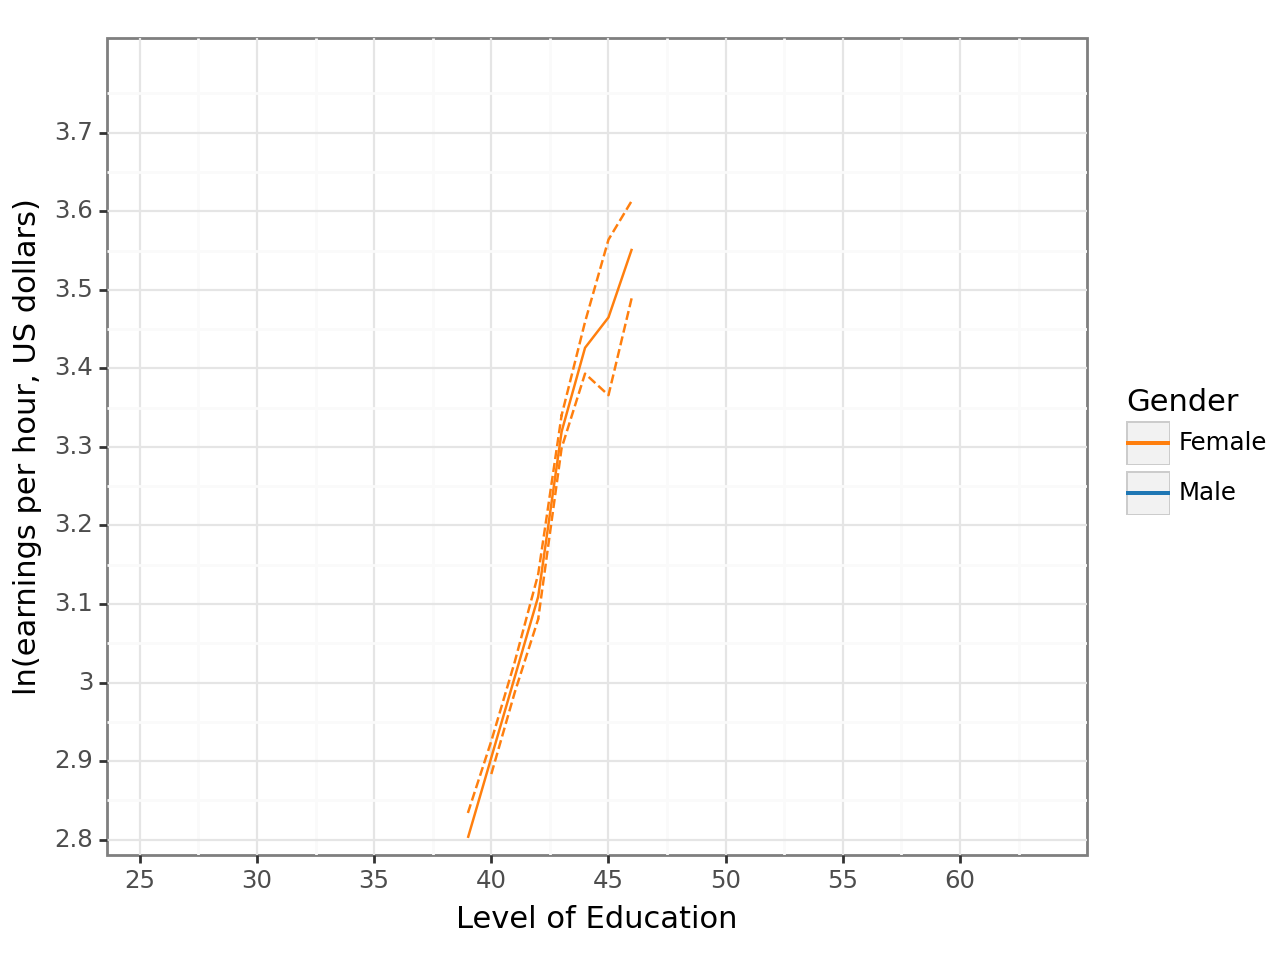

In [128]:
from plotnine import ggplot, aes, geom_line, labs, scale_color_manual, scale_x_continuous, scale_y_continuous, theme_bw, guides, guide_legend
import numpy as np
import pandas as pd

# Assuming color[0] is for males and color[1] is for females
color = ["#1f77b4", "#ff7f0e"]

# Adding a 'sex' column to differentiate males and females
data_m['sex'] = 'Male'
data_f['sex'] = 'Female'

# Combining the datasets to plot them together
data_combined = pd.concat([data_m, data_f])

plot = (
    ggplot(data_combined, aes(x="grade92", y="fit", color='sex')) +  # 'sex' is now a column in the data
    geom_line() +  # Plot the line for fit values
    geom_line(aes(y="CIup"), linetype="dashed") +  # Plot the upper CI
    geom_line(aes(y="CIlo"), linetype="dashed") +  # Plot the lower CI
    labs(x="Level of Education", y="ln(earnings per hour, US dollars)", color="Gender") +  # Define axis labels and plot title
    scale_color_manual(values={'Male': color[0], 'Female': color[1]}) +  # Define manual colors for lines
    scale_x_continuous(expand=(0.01, 0.01), limits=(24, 65), breaks=np.arange(25, 65, 5)) +  # Configure the x-axis
    scale_y_continuous(expand=(0.01, 0.01), limits=(2.8, 3.8), breaks=np.arange(2.8, 3.8, 0.1)) +  # Configure the y-axis
    theme_bw() +  # Apply a black-and-white theme
    guides(color=guide_legend(title="Gender"))  # Add a legend with title "Gender"
)

print(plot)
